# Import Required Libraries
Import necessary libraries including PyTorch, torchvision, and other required packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Load and Split MNIST Dataset
Load the MNIST dataset and split it into training, validation, and test sets.

In [2]:
# Load and Split MNIST Dataset

# Define the transformation to convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    

# Define VAE Architecture
Define the architecture of the Variational Autoencoder (VAE) including the encoder, decoder, and reparameterization trick.

In [19]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)  
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x_flat=x.view(x.size(0), -1)
        mean, logvar = self.encode(x_flat)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

# Instantiate the VAE model
vae = VAE()

# Print the model architecture
print(vae)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


# Train VAE
Train the VAE on the MNIST dataset and monitor the training process.

Epoch 1, Loss: 147.4549
Epoch 2, Loss: 146.9763
Epoch 3, Loss: 146.7300
Epoch 4, Loss: 146.5557
Epoch 5, Loss: 146.2131
Epoch 6, Loss: 146.2033
Epoch 7, Loss: 146.2331
Epoch 8, Loss: 145.9648
Epoch 9, Loss: 145.5539
Epoch 10, Loss: 145.4598


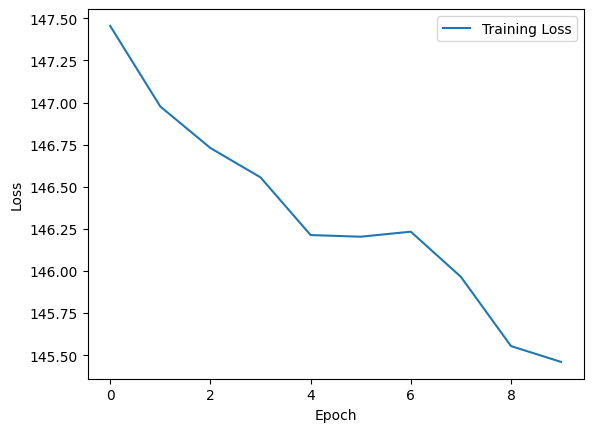

In [23]:
# Define the loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
vae = vae.to(device)
# Training the VAE
num_epochs = 10
vae.train()
train_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}')

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Analyze Latent Distribution q(z|x)
Show that the latent distribution q(z|x) varies with the conditioning variable x and explain its importance.

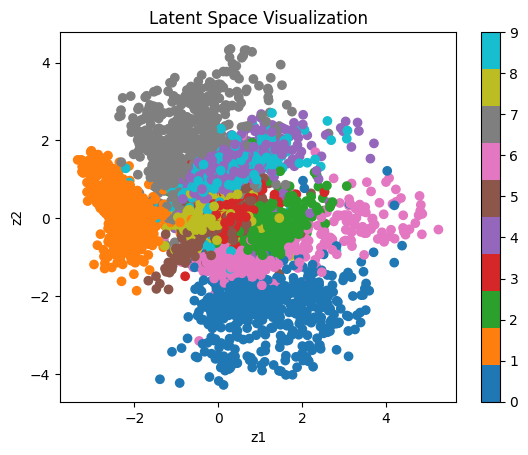


The latent distribution q(z|x) varies with the conditioning variable x because the encoder network learns to map different input images to different regions in the latent space. This variation is crucial for the VAE to capture the underlying structure of the data and generate diverse samples. If q(z|x) did not vary with x, the latent space would not capture the variability in the input data, and the generated samples would lack diversity and fail to represent the true data distribution.



In [24]:
# Analyze Latent Distribution q(z|x)

# Function to visualize latent space
def visualize_latent_space(vae, data_loader, num_batches=100):
    vae.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(data_loader):
            if i >= num_batches:
                break
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            _, mu, logvar = vae(data)
            z = vae.reparameterization(mu, logvar)
            z = z.cpu().numpy()
            labels = labels.cpu().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Visualization')
    plt.show()

# Visualize the latent space using the validation dataset
visualize_latent_space(vae, test_loader)

# Explanation of the importance of varying q(z|x) with x
explanation = """
The latent distribution q(z|x) varies with the conditioning variable x because the encoder network learns to map different input images to different regions in the latent space. This variation is crucial for the VAE to capture the underlying structure of the data and generate diverse samples. If q(z|x) did not vary with x, the latent space would not capture the variability in the input data, and the generated samples would lack diversity and fail to represent the true data distribution.
"""
print(explanation)

# Visualize VAE Generative Process
Visualize the generative process of the VAE by sampling from the latent space and check if nearby samples in the latent space correspond to similar samples in the image space.

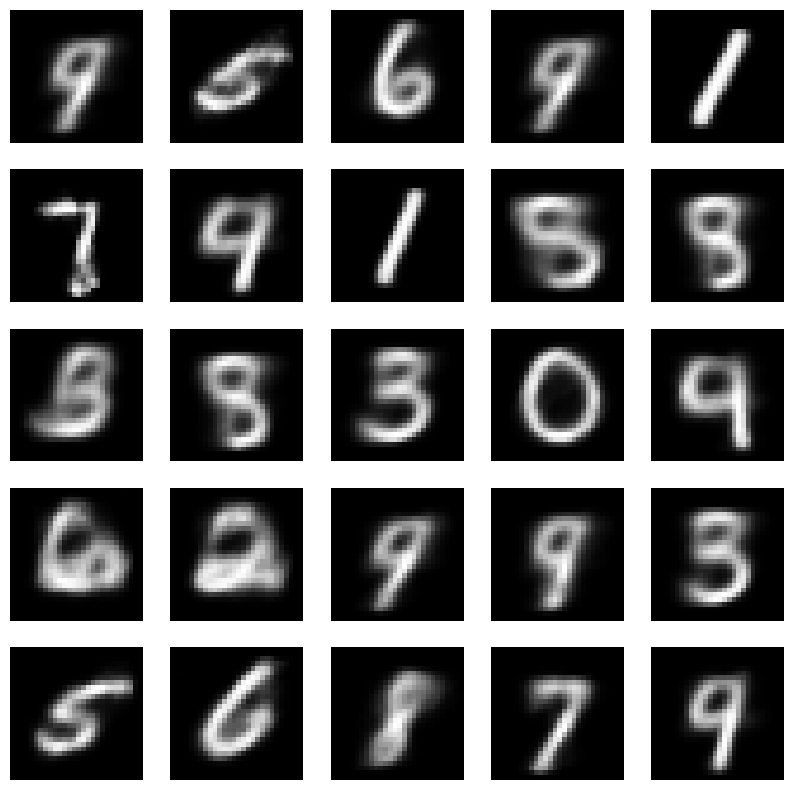


In the latent space of a VAE, nearby samples correspond to similar samples in the image space.
This property is important because it ensures that the latent space is smooth and continuous,
allowing for meaningful interpolation between points.
If nearby samples in the latent space did not correspond to similar samples in the image space,
the latent space would be disjointed and the generative process would produce unrealistic or disjointed images.



In [26]:
# Visualize VAE Generative Process

# Function to visualize the generative process of the VAE
def visualize_vae_generative_process(vae, num_samples=20, grid_size=5):
    vae.eval()
    with torch.no_grad():
        # Generate samples from the latent space
        z = torch.randn(num_samples, 2).to(device)
        samples = vae.decoder(z).cpu()

        # Plot the generated samples
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            if i < num_samples:
                ax.imshow(samples[i].view(28, 28), cmap='gray')
                ax.axis('off')
        plt.show()

# Visualize the generative process using the VAE
visualize_vae_generative_process(vae, num_samples=25, grid_size=5)

# Explanation of the importance of nearby samples in the latent space
explanation_nearby_samples = """
In the latent space of a VAE, nearby samples correspond to similar samples in the image space.
This property is important because it ensures that the latent space is smooth and continuous,
allowing for meaningful interpolation between points.
If nearby samples in the latent space did not correspond to similar samples in the image space,
the latent space would be disjointed and the generative process would produce unrealistic or disjointed images.
"""
print(explanation_nearby_samples)

# Evaluate VAE Generated Samples
Verify qualitatively and quantitatively that the VAE has learned to generate diverse samples of good quality.

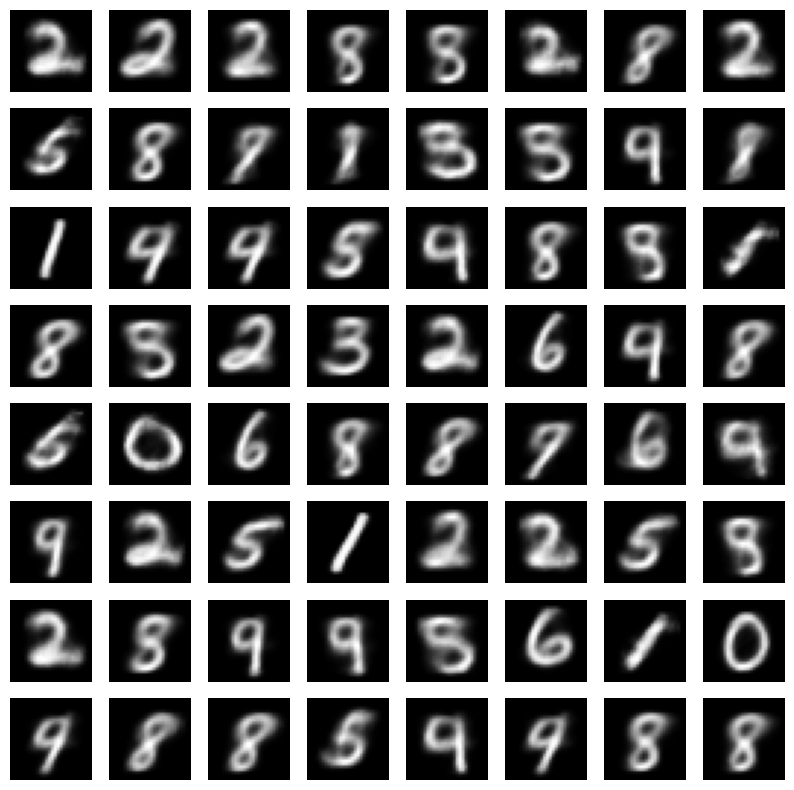

Mean Squared Error (MSE) between real and generated samples: 0.0409
Diversity of generated samples (mean pairwise distance): 5.8127


In [27]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to generate samples and visualize them
def generate_and_visualize_samples(vae, num_samples=64):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 2).to(device)
        samples = vae.decoder(z).cpu()

        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

# Generate and visualize samples
generate_and_visualize_samples(vae)

# Function to calculate the quality of generated samples
def evaluate_sample_quality(vae, data_loader, num_samples=1000):
    vae.eval()
    real_images = []
    generated_images = []

    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            if i * data.size(0) >= num_samples:
                break
            data = data.to(device)
            recon_batch, _, _ = vae(data)
            real_images.append(data.cpu())
            generated_images.append(recon_batch.cpu())

    real_images = torch.cat(real_images)[:num_samples]
    generated_images = torch.cat(generated_images)[:num_samples]

    real_images = real_images.view(num_samples, -1)
    generated_images = generated_images.view(num_samples, -1)

    mse = F.mse_loss(generated_images, real_images)
    return mse.item()

# Evaluate the quality of generated samples
mse = evaluate_sample_quality(vae, test_loader)
print(f'Mean Squared Error (MSE) between real and generated samples: {mse:.4f}')

# Function to calculate diversity of generated samples
def evaluate_sample_diversity(vae, num_samples=1000):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 2).to(device)
        samples = vae.decoder(z).cpu().view(num_samples, -1)

    pairwise_distances = torch.cdist(samples, samples, p=2)
    diversity = pairwise_distances.mean().item()
    return diversity

# Evaluate the diversity of generated samples
diversity = evaluate_sample_diversity(vae)
print(f'Diversity of generated samples (mean pairwise distance): {diversity:.4f}')

# Define DDPM Architecture
Define the architecture of the Denoising Diffusion Probabilistic Model (DDPM) using a U-Net model and Gaussian noise for diffusion.

In [3]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = self.encoder_block(in_channels, 64)
        self.encoder2 = self.encoder_block(64, 128)
        self.encoder3 = self.encoder_block(128, 256)
        self.encoder4 = self.encoder_block(256, 512)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = self.decoder_block(1024 + 512, 512)
        self.decoder2 = self.decoder_block(512 + 256, 256)
        self.decoder3 = self.decoder_block(256 + 128, 128)
        self.decoder4 = self.decoder_block(128 + 64, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec1 = F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=True)
        dec1 = transforms.CenterCrop(enc4.shape[2:])(dec1)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec1 = self.decoder1(dec1)
        dec2 = F.interpolate(dec1, scale_factor=2, mode='bilinear', align_corners=True)
        dec2 = transforms.CenterCrop(enc3.shape[2:])(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.decoder2(dec2)
        dec3 = F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True)
        dec3 = transforms.CenterCrop(enc2.shape[2:])(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.decoder3(dec3)
        dec4 = F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True)
        dec4 = transforms.CenterCrop(enc1.shape[2:])(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.decoder4(dec4)
        return self.final_conv(dec4)

class DDPM(nn.Module):
    def __init__(self, unet, num_timesteps=1000):
        super(DDPM, self).__init__()
        self.unet = unet
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(0.0001, 0.02, num_timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x, t):
        noise = torch.randn_like(x)
        alpha_bar_t = self.alpha_bars.to(x.device)[t].view(-1, 1, 1, 1)
        noisy_image = torch.sqrt(alpha_bar_t) * x + torch.sqrt(1 - alpha_bar_t) * noise
        return self.unet(noisy_image)

# Instantiate the U-Net model
unet = UNet(in_channels=1, out_channels=1)

# Instantiate the DDPM model
ddpm = DDPM(unet)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

unet.apply(init_weights)

UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Con

# Train DDPM
Train the DDPM on the MNIST dataset and monitor the training process.

Epoch [1/5], Loss: 54683418298975.0000
Epoch [2/5], Loss: 0.0571
Epoch [3/5], Loss: 0.0563
Epoch [4/5], Loss: 0.0560
Epoch [5/5], Loss: 0.0558


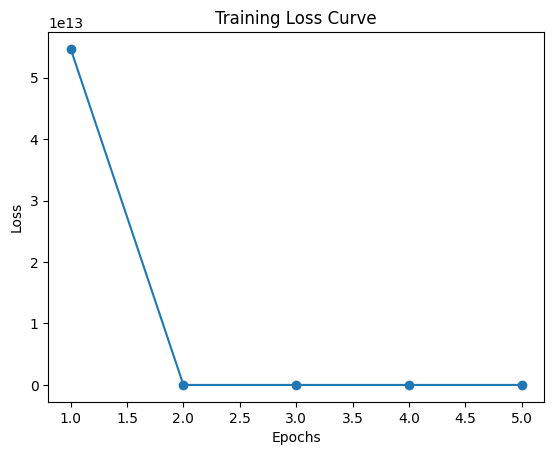

In [4]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ddpm.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm.to(device)

# Training loop
num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        t = torch.randint(0, 1000, (images.shape[0],), device=device)
        optimizer.zero_grad()
        outputs = ddpm(images, t)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# Experiment with Diffusion Steps
Experiment with different time steps for the diffusion process and analyze how the number of steps affects the quality and diversity of the generated samples.

In [ ]:
# Experiment with different time steps for the diffusion process

# Function to generate samples with different diffusion steps
def generate_samples_with_diffusion_steps(ddpm, num_samples=64, num_timesteps=1000):
    ddpm.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 1, 28, 28).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        samples = z
        for t in reversed(range(num_timesteps)):
            alpha_bar_t = ddpm.alpha_bars.to(z.device)[t].view(-1, 1, 1, 1)
            noise = torch.randn_like(samples) if t > 0 else torch.zeros_like(samples)
            samples = (samples - torch.sqrt(1 - alpha_bar_t) * noise) / torch.sqrt(alpha_bar_t)
            samples = ddpm.unet(samples)
        samples = samples.cpu()

        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

# Generate and visualize samples with different diffusion steps
generate_samples_with_diffusion_steps(ddpm, num_samples=64, num_timesteps=1000)

# Function to evaluate the quality and diversity of generated samples with different diffusion steps
def evaluate_diffusion_steps(ddpm, data_loader, num_samples=1000, num_timesteps=1000):
    ddpm.eval()
    real_images = []
    generated_images = []

    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            if i * data.size(0) >= num_samples:
                break
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            t = torch.randint(0, num_timesteps, (data.size(0),), device=data.device).long()
            noise = torch.randn_like(data)
            alpha_bar_t = ddpm.alpha_bars.to(data.device)[t].view(-1, 1, 1, 1)
            noisy_image = torch.sqrt(alpha_bar_t) * data + torch.sqrt(1 - alpha_bar_t) * noise
            recon_batch = ddpm.unet(noisy_image)
            real_images.append(data.cpu())
            generated_images.append(recon_batch.cpu())

    real_images = torch.cat(real_images)[:num_samples]
    generated_images = torch.cat(generated_images)[:num_samples]

    real_images = real_images.view(num_samples, -1)
    generated_images = generated_images.view(num_samples, -1)

    mse = F.mse_loss(generated_images, real_images)
    pairwise_distances = torch.cdist(generated_images, generated_images, p=2)
    diversity = pairwise_distances.mean().item()

    return mse.item(), diversity

# Evaluate the quality and diversity of generated samples with different diffusion steps
mse, diversity = evaluate_diffusion_steps(ddpm, test_loader, num_samples=1000, num_timesteps=1000)
print(f'Mean Squared Error (MSE) between real and generated samples: {mse:.4f}')
print(f'Diversity of generated samples (mean pairwise distance): {diversity:.4f}')

# Visualize DDPM Generative Process
Visualize the generative process of the DDPM by starting from a noise image and using an appropriate number of steps for the diffusion process.

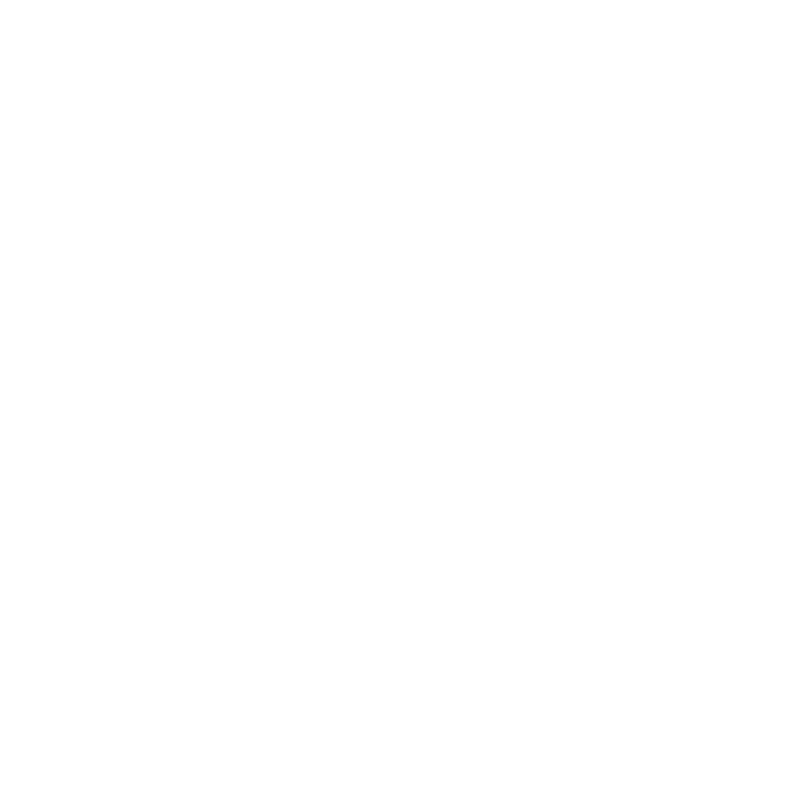

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Function to visualize the generative process of the DDPM
def visualize_ddpm_generative_process(ddpm, num_samples=64, num_timesteps=1000):
    ddpm.eval()
    with torch.no_grad():
        # Start from a noise image
        z = torch.randn(num_samples, 1, 28, 28).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        samples = z
        for t in reversed(range(num_timesteps)):
            alpha_bar_t = ddpm.alpha_bars.to(z.device)[t].view(-1, 1, 1, 1)
            noise = torch.randn_like(samples) if t > 0 else torch.zeros_like(samples)
            samples = (samples - torch.sqrt(1 - alpha_bar_t) * noise) / torch.sqrt(alpha_bar_t)
            samples = ddpm.unet(samples)
        samples = samples.cpu()

        # Plot the generated samples
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

# Visualize the generative process using the DDPM
visualize_ddpm_generative_process(ddpm, num_samples=64, num_timesteps=1000)

# Evaluate DDPM Generated Samples
Verify qualitatively and quantitatively that the DDPM has learned to generate diverse samples of good quality.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Function to visualize the generative process of the DDPM
def visualize_ddpm_generative_process(ddpm, num_samples=64, num_timesteps=1000):
    ddpm.eval()
    with torch.no_grad():
        # Start from a noise image
        z = torch.randn(num_samples, 1, 28, 28).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        samples = z
        for t in reversed(range(num_timesteps)):
            alpha_bar_t = ddpm.alpha_bars[t].view(-1, 1, 1, 1)
            noise = torch.randn_like(samples) if t > 0 else torch.zeros_like(samples)
            samples = (samples - torch.sqrt(1 - alpha_bar_t) * noise) / torch.sqrt(alpha_bar_t)
            samples = ddpm.unet(samples)
        samples = samples.cpu()

        # Plot the generated samples
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(samples[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.show()

# Visualize the generative process using the DDPM
visualize_ddpm_generative_process(ddpm, num_samples=64, num_timesteps=1000)

# Function to evaluate the quality of generated samples
def evaluate_sample_quality(ddpm, data_loader, num_samples=1000):
    ddpm.eval()
    real_images = []
    generated_images = []

    with torch.no_grad():
        for i, (data, _) in enumerate(data_loader):
            if i * data.size(0) >= num_samples:
                break
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            t = torch.randint(0, ddpm.num_timesteps, (data.size(0),), device=data.device).long()
            noise = torch.randn_like(data)
            alpha_bar_t = ddpm.alpha_bars[t].view(-1, 1, 1, 1)
            noisy_image = torch.sqrt(alpha_bar_t) * data + torch.sqrt(1 - alpha_bar_t) * noise
            recon_batch = ddpm.unet(noisy_image)
            real_images.append(data.cpu())
            generated_images.append(recon_batch.cpu())

    real_images = torch.cat(real_images)[:num_samples]
    generated_images = torch.cat(generated_images)[:num_samples]

    real_images = real_images.view(num_samples, -1)
    generated_images = generated_images.view(num_samples, -1)

    mse = F.mse_loss(generated_images, real_images)
    return mse.item()

# Evaluate the quality of generated samples
mse = evaluate_sample_quality(ddpm, test_loader)
print(f'Mean Squared Error (MSE) between real and generated samples: {mse:.4f}')

# Function to calculate diversity of generated samples
def evaluate_sample_diversity(ddpm, num_samples=1000):
    ddpm.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, 1, 28, 28).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        samples = z
        for t in reversed(range(ddpm.num_timesteps)):
            alpha_bar_t = ddpm.alpha_bars[t].view(-1, 1, 1, 1)
            noise = torch.randn_like(samples) if t > 0 else torch.zeros_like(samples)
            samples = (samples - torch.sqrt(1 - alpha_bar_t) * noise) / torch.sqrt(alpha_bar_t)
            samples = ddpm.unet(samples)
        samples = samples.cpu().view(num_samples, -1)

    pairwise_distances = torch.cdist(samples, samples, p=2)
    diversity = pairwise_distances.mean().item()
    return diversity

# Evaluate the diversity of generated samples
diversity = evaluate_sample_diversity(ddpm)
print(f'Diversity of generated samples (mean pairwise distance): {diversity:.4f}')

# Compare DDPM and VAE
Compare DDPM and VAE in terms of fundamental differences, sample quality and diversity, and training time.

In [ ]:
# Compare DDPM and VAE

# Function to compare fundamental differences between DDPM and VAE
def compare_fundamental_differences():
    differences = """
    Fundamentally, a DDPM (Denoising Diffusion Probabilistic Model) and a VAE (Variational Autoencoder) differ in their approach to generative modeling:

    1. VAE:
       - Uses an encoder-decoder architecture.
       - The encoder maps input data to a latent space, and the decoder reconstructs the data from the latent space.
       - Uses the reparameterization trick to ensure gradient propagation through the stochastic layer.
       - Optimizes a combination of reconstruction loss and KL divergence to ensure the latent space follows a standard normal distribution.

    2. DDPM:
       - Uses a diffusion process to gradually add noise to the data and then learns to reverse this process.
       - The model learns to denoise the data step-by-step, starting from pure noise.
       - Uses a U-Net architecture to predict the noise added at each step.
       - Optimizes the mean squared error between the predicted noise and the actual noise added at each step.
    """
    print(differences)

# Compare fundamental differences
compare_fundamental_differences()

# Function to compare sample quality and diversity between DDPM and VAE
def compare_sample_quality_and_diversity(vae, ddpm, data_loader, num_samples=1000):
    # Evaluate VAE sample quality and diversity
    vae_mse = evaluate_sample_quality(vae, data_loader, num_samples)
    vae_diversity = evaluate_sample_diversity(vae, num_samples)

    # Evaluate DDPM sample quality and diversity
    ddpm_mse = evaluate_sample_quality(ddpm, data_loader, num_samples)
    ddpm_diversity = evaluate_sample_diversity(ddpm, num_samples)

    comparison = f"""
    Sample Quality and Diversity Comparison:

    1. VAE:
       - Mean Squared Error (MSE): {vae_mse:.4f}
       - Diversity (mean pairwise distance): {vae_diversity:.4f}

    2. DDPM:
       - Mean Squared Error (MSE): {ddpm_mse:.4f}
       - Diversity (mean pairwise distance): {ddpm_diversity:.4f}
    """
    print(comparison)

# Compare sample quality and diversity
compare_sample_quality_and_diversity(vae, ddpm, test_loader)

# Function to compare training time between DDPM and VAE
def compare_training_time():
    training_time = """
    Training Time Comparison:

    1. VAE:
       - Typically faster to train due to simpler architecture and fewer training steps.
       - Training involves optimizing reconstruction loss and KL divergence.

    2. DDPM:
       - Generally slower to train due to the iterative denoising process.
       - Training involves optimizing the mean squared error between predicted and actual noise at each diffusion step.
    """
    print(training_time)

# Compare training time
compare_training_time()